In [2]:
from bs4 import BeautifulSoup
import requests
from random import randint
import re
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os

In [3]:
df = pd.read_csv('zillow_house_features.csv')

In [4]:
df.head(10)

,price,bed,bath,sqft,address,zip_code,house_type,year_built,heating,cooling,parking,lot_size,zestimate,num_photos,url
0,1925000.0,2.0,2.0,1212.0,"580 Carroll St #1A, Brooklyn, NY 11215",11215.0,Condo,2009,Forced air,Central,Garage - Attached,10174.0,NaN,13.0,https://www.zillow.com/homedetails/580-Carroll...
1,489000.0,2.0,1.0,NaN,"70-25 Yellowstone Blvd #20Y, Forest Hills, NY ...",11375.0,Cooperative,1965,No Data,Central,0 spaces,NaN,NaN,20.0,https://www.zillow.com/homedetails/70-25-Yello...
2,330000.0,4.0,2.0,1629.0,"19018 114th Dr, Saint Albans, NY 11412",11412.0,SingleFamily,1930,No Data,No Data,"Garage - Detached,",5057.0,324957.0,3.0,https://www.zillow.com/homedetails/19018-114th...
3,799000.0,5.0,5.0,NaN,"10617 154th St, Jamaica, NY 11433",11433.0,Multi Family,1910,"Natural Gas, Hot Water",No Data,None,2178.0,NaN,7.0,https://www.zillow.com/homedetails/10617-154th...
4,559000.0,3.0,3.0,1800.0,"40 Danny Ct, Staten Island, NY 10314",10314.0,SingleFamily,2003,"Forced air, Gas",Central,"Carport,",1711.0,545847.0,25.0,https://www.zillow.com/homedetails/40-Danny-Ct...
5,738888.0,4.0,3.0,1860.0,"145 Leverett Ave, Staten Island, NY 10308",10308.0,Single Family - Detached,1960,"Forced Air, Natural Gas",Central Air,"Built-in, Garage, Off Street",4000.0,660136.0,68.0,https://www.zillow.com/homedetails/145-Leveret...
6,569900.0,3.0,4.0,1747.0,"Price cut: $10K (5/5)446 Westervelt Ave, State...",10301.0,Single Family - Detached,2021,"Forced Air, Natural Gas",Central Air,"No Garage, Carport, Off Street",2090.0,534873.0,39.0,https://www.zillow.com/homedetails/446-Westerv...
7,1225000.0,5.0,3.0,2272.0,"358 74th St, Brooklyn, NY 11209",11209.0,MultiFamily,1901,No Data,No Data,0 spaces,1742.0,1197438.0,41.0,https://www.zillow.com/homedetails/358-74th-St...
8,299000.0,3.0,3.0,1260.0,"43 Paris Ct, Staten Island, NY 10310",10310.0,Single Family - Attached,2003,"Forced Air, Natural Gas",None,"No Garage, Assigned",1666.0,418427.0,20.0,https://www.zillow.com/homedetails/43-Paris-Ct...
9,689999.0,3.0,2.0,NaN,"95-15 Pitkin Ave, Ozone Park, NY 11417",11417.0,Single Family Residence,1925,"Natural Gas, Hot Water",No Data,"Private, Detached, 1 Car Detached",2178.0,NaN,1.0,https://www.zillow.com/homedetails/95-15-Pitki...


In [5]:
df.shape

(1565, 15)

In [6]:
df.isnull().sum()

price           3
bed            60
bath           17
sqft          194
address         2
zip_code        2
house_type     12
year_built     12
heating        12
cooling        12
parking        12
lot_size      324
zestimate     400
num_photos      1
url             0
dtype: int64

# Data Cleaning 

### Dealing with Nulls

In [7]:
#Since price is our target, and it only had 3 nulls I wanted to fill nulls with zestimate. 
#Unfortunately zestimate was also null for those rows, so I dropped the 3 nulls
#df.loc[(df['price'].isna()) | (df['price'] == 0  ), 'price'] = df['zestimate']   #code to replace price nulls with 
                                                                                  #zestimate

#Dropping nulls in price column    
df.dropna(subset = ['price'], inplace = True)
df.head(2)

,price,bed,bath,sqft,address,zip_code,house_type,year_built,heating,cooling,parking,lot_size,zestimate,num_photos,url
0,1925000.0,2.0,2.0,1212.0,"580 Carroll St #1A, Brooklyn, NY 11215",11215.0,Condo,2009,Forced air,Central,Garage - Attached,10174.0,NaN,13.0,https://www.zillow.com/homedetails/580-Carroll...
1,489000.0,2.0,1.0,NaN,"70-25 Yellowstone Blvd #20Y, Forest Hills, NY ...",11375.0,Cooperative,1965,No Data,Central,0 spaces,NaN,NaN,20.0,https://www.zillow.com/homedetails/70-25-Yello...


In [414]:
df.isnull().sum()

price           0
bed            58
bath           15
sqft          192
address         0
zip_code        0
house_type      9
year_built      9
heating         9
cooling         9
parking         9
lot_size      321
zestimate     397
num_photos      0
url             0
dtype: int64

In [8]:
#Since beds will likely be an important feature for price prediction, it is important to fillna those rows
#Usually bed is bath+1, I can verify by subtracting the avg number of beds by avg number of baths:

mean_beds= df.bed.mean()
mean_baths= df.bath.mean()
difference_beds_bath= mean_beds - mean_baths
print(difference_beds_bath)


0.7497150455927049


In [9]:
#Not quite 1, but lets add that number to beds: 

#Making a new column to store bath+ 0.7497150455927049 values
df['new'] = df['bath']+ 0.7497150455927049

#Filling nulls with corresponding rows from 'new' column 
df.loc[(df['bed'].isna()) | (df['bed'] == 0), 'bed'] = df['new']

df.head(2)

,price,bed,bath,sqft,address,zip_code,house_type,year_built,heating,cooling,parking,lot_size,zestimate,num_photos,url,new
0,1925000.0,2.0,2.0,1212.0,"580 Carroll St #1A, Brooklyn, NY 11215",11215.0,Condo,2009,Forced air,Central,Garage - Attached,10174.0,NaN,13.0,https://www.zillow.com/homedetails/580-Carroll...,2.749715
1,489000.0,2.0,1.0,NaN,"70-25 Yellowstone Blvd #20Y, Forest Hills, NY ...",11375.0,Cooperative,1965,No Data,Central,0 spaces,NaN,NaN,20.0,https://www.zillow.com/homedetails/70-25-Yello...,1.749715


In [75]:
df.isnull().sum()

price           0
bed            12
bath           15
sqft          192
address         0
zip_code        0
house_type      9
year_built      9
heating         9
cooling         9
parking         9
lot_size      321
zestimate     397
num_photos      0
url             0
new            15
dtype: int64

In [134]:
df.shape

(1562, 16)

In [10]:
#Since bed is likely an important feature, and there's no other way to fill those missing values
#I will drop the remaining 12 rows from the 'bed' column:
#I prefer not to fillna important features like this with mean because I want to test my model 
#on real data as much as possible 

df.dropna(subset=['bed', 'sqft', 'bath'], inplace=True)
df.isnull().sum()

price           0
bed             0
bath            0
sqft            0
address         0
zip_code        0
house_type      0
year_built      0
heating         0
cooling         0
parking         0
lot_size      215
zestimate     314
num_photos      0
url             0
new             0
dtype: int64

In [11]:
#No longer need zestimate, will keep only relavent features: 
df= df[['price', 'bed', 'bath', 'sqft', 'zip_code', 'house_type', 'year_built', 'heating', 'cooling', 'parking', 'lot_size', 'num_photos']]
df.head(2)

,price,bed,bath,sqft,zip_code,house_type,year_built,heating,cooling,parking,lot_size,num_photos
0,1925000.0,2.0,2.0,1212.0,11215.0,Condo,2009,Forced air,Central,Garage - Attached,10174.0,13.0
2,330000.0,4.0,2.0,1629.0,11412.0,SingleFamily,1930,No Data,No Data,"Garage - Detached,",5057.0,3.0


In [12]:
df.rename(columns= {'zip_code': 'zip'}, inplace = True)
df.head(2)

,price,bed,bath,sqft,zip,house_type,year_built,heating,cooling,parking,lot_size,num_photos
0,1925000.0,2.0,2.0,1212.0,11215.0,Condo,2009,Forced air,Central,Garage - Attached,10174.0,13.0
2,330000.0,4.0,2.0,1629.0,11412.0,SingleFamily,1930,No Data,No Data,"Garage - Detached,",5057.0,3.0


In [13]:
census= pd.read_csv('project2_census.csv')
census.head(2)

,zip,population,density,Average household income
0,6390,125.0,11.9,"$50,521.00"
1,10001,24117.0,15153.7,"$40,932.00"


In [14]:
df= pd.merge(df, census, how='left',  on = 'zip')

In [422]:
df.head(2)

,price,bed,bath,sqft,zip,house_type,year_built,heating,cooling,parking,lot_size,num_photos,population,density,Average household income
0,1925000.0,2.0,2.0,1212.0,11215.0,Condo,2009,Forced air,Central,Garage - Attached,10174.0,13.0,69873.0,12404.0,"$53,313.00"
1,330000.0,4.0,2.0,1629.0,11412.0,SingleFamily,1930,No Data,No Data,"Garage - Detached,",5057.0,3.0,37857.0,8874.3,"$48,536.00"


In [423]:
df.isnull().sum()

price                         0
bed                           0
bath                          0
sqft                          0
zip                           0
house_type                    0
year_built                    0
heating                       0
cooling                       0
parking                       0
lot_size                    215
num_photos                    0
population                   17
density                      17
Average household income     17
dtype: int64

In [142]:
df.shape

(1365, 14)

## Dropping nulls from remaining columns

In [15]:
df.dropna(subset=['density', 'population', 'Average household income'], inplace=True)
df.isnull().sum()

price                         0
bed                           0
bath                          0
sqft                          0
zip                           0
house_type                    0
year_built                    0
heating                       0
cooling                       0
parking                       0
lot_size                    204
num_photos                    0
population                    0
density                       0
Average household income      0
dtype: int64

In [425]:
#Some houses have no lots,but we still want data for those houses. We can create a dummy for NaN values later

In [16]:
df['Average household income'].dtypes

dtype('O')

In [17]:
#Remove currency symbol ($) in Average household income:
df['Average household income'] = df['Average household income'].apply(lambda x: x.replace('$','')).apply(lambda x: x.replace(',',''))

df.head(2)

,price,bed,bath,sqft,zip,house_type,year_built,heating,cooling,parking,lot_size,num_photos,population,density,Average household income
0,1925000.0,2.0,2.0,1212.0,11215.0,Condo,2009,Forced air,Central,Garage - Attached,10174.0,13.0,69873.0,12404.0,53313.00
1,330000.0,4.0,2.0,1629.0,11412.0,SingleFamily,1930,No Data,No Data,"Garage - Detached,",5057.0,3.0,37857.0,8874.3,48536.00


In [18]:
#Convert string to numeric in Average household income:
df['Average household income'] = pd.to_numeric(df['Average household income'], errors='coerce')
df.head(2)

,price,bed,bath,sqft,zip,house_type,year_built,heating,cooling,parking,lot_size,num_photos,population,density,Average household income
0,1925000.0,2.0,2.0,1212.0,11215.0,Condo,2009,Forced air,Central,Garage - Attached,10174.0,13.0,69873.0,12404.0,53313.0
1,330000.0,4.0,2.0,1629.0,11412.0,SingleFamily,1930,No Data,No Data,"Garage - Detached,",5057.0,3.0,37857.0,8874.3,48536.0


In [429]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1348 entries, 0 to 1364
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   price                     1348 non-null   float64
 1   bed                       1348 non-null   float64
 2   bath                      1348 non-null   float64
 3   sqft                      1348 non-null   float64
 4   zip                       1348 non-null   float64
 5   house_type                1348 non-null   object 
 6   year_built                1348 non-null   object 
 7   heating                   1348 non-null   object 
 8   cooling                   1348 non-null   object 
 9   parking                   1348 non-null   object 
 10  lot_size                  1144 non-null   float64
 11  num_photos                1348 non-null   float64
 12  population                1348 non-null   float64
 13  density                   1348 non-null   float64
 14  Average 

In [20]:
#Fill'No data' rows in year_built with 0's in order to convert from object to int type:

df['year_built'] = df['year_built'].fillna(0)

In [21]:
df['year_built'].isna().sum()

0

In [22]:
#Convert string to numeric in year_built:
df['year_built'] = pd.to_numeric(df['year_built'], errors='coerce')
df.head(2)

,price,bed,bath,sqft,zip,house_type,year_built,heating,cooling,parking,lot_size,num_photos,population,density,Average household income
0,1925000.0,2.0,2.0,1212.0,11215.0,Condo,2009.0,Forced air,Central,Garage - Attached,10174.0,13.0,69873.0,12404.0,53313.0
1,330000.0,4.0,2.0,1629.0,11412.0,SingleFamily,1930.0,No Data,No Data,"Garage - Detached,",5057.0,3.0,37857.0,8874.3,48536.0


In [23]:
df['year_built'] = df['year_built'].fillna(0)

In [24]:
#Convert year_built from float to int type:

df['year_built']= df['year_built'].astype(int)



In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1348 entries, 0 to 1364
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   price                     1348 non-null   float64
 1   bed                       1348 non-null   float64
 2   bath                      1348 non-null   float64
 3   sqft                      1348 non-null   float64
 4   zip                       1348 non-null   float64
 5   house_type                1348 non-null   object 
 6   year_built                1348 non-null   int64  
 7   heating                   1348 non-null   object 
 8   cooling                   1348 non-null   object 
 9   lot_size                  1144 non-null   float64
 10  num_photos                1348 non-null   float64
 11  population                1348 non-null   float64
 12  density                   1348 non-null   float64
 13  Average household income  1348 non-null   float64
dtypes: float

In [435]:
df.head(2)

,price,bed,bath,sqft,zip,house_type,year_built,heating,cooling,parking,lot_size,num_photos,population,density,Average household income
0,1925000.0,2.0,2.0,1212.0,11215.0,Condo,2009,Forced air,Central,Garage - Attached,10174.0,13.0,69873.0,12404.0,53313.0
1,330000.0,4.0,2.0,1629.0,11412.0,SingleFamily,1930,No Data,No Data,"Garage - Detached,",5057.0,3.0,37857.0,8874.3,48536.0


In [25]:
#convert house built year to age of house based on current year
df['House_age'] = 2021 - df['year_built']

In [437]:
df.head(2)

,price,bed,bath,sqft,zip,house_type,year_built,heating,cooling,parking,lot_size,num_photos,population,density,Average household income,House_age
0,1925000.0,2.0,2.0,1212.0,11215.0,Condo,2009,Forced air,Central,Garage - Attached,10174.0,13.0,69873.0,12404.0,53313.0,12
1,330000.0,4.0,2.0,1629.0,11412.0,SingleFamily,1930,No Data,No Data,"Garage - Detached,",5057.0,3.0,37857.0,8874.3,48536.0,91


In [26]:
#rearrange columns

df = df[['bed','bath','sqft','year_built','House_age','lot_size','house_type', 'heating', 'cooling','parking', 'num_photos','zip','population', 'density', 'Average household income', 'price' ]]
df.head(3)


,bed,bath,sqft,year_built,House_age,lot_size,house_type,heating,cooling,parking,num_photos,zip,population,density,Average household income,price
0,2.0,2.0,1212.0,2009,12,10174.0,Condo,Forced air,Central,Garage - Attached,13.0,11215.0,69873.0,12404.0,53313.0,1925000.0
1,4.0,2.0,1629.0,1930,91,5057.0,SingleFamily,No Data,No Data,"Garage - Detached,",3.0,11412.0,37857.0,8874.3,48536.0,330000.0
2,3.0,3.0,1800.0,2003,18,1711.0,SingleFamily,"Forced air, Gas",Central,"Carport,",25.0,10314.0,89792.0,2534.2,59560.0,559000.0


In [439]:
df.isna().sum()

bed                           0
bath                          0
sqft                          0
year_built                    0
House_age                     0
lot_size                    204
house_type                    0
heating                       0
cooling                       0
parking                       0
num_photos                    0
zip                           0
population                    0
density                       0
Average household income      0
price                         0
dtype: int64

In [27]:
#reconvert select columns to int type:
df = df.astype({'bed': np.int64,'bath': np.int64,'year_built': np.int64, 'House_age': np.int64,'num_photos': np.int64, 'zip': np.int64})
                  
df

,bed,bath,sqft,year_built,House_age,lot_size,house_type,heating,cooling,parking,num_photos,zip,population,density,Average household income,price
0,2,2,1212.0,2009,12,10174.0,Condo,Forced air,Central,Garage - Attached,13,11215,69873.0,12404.0,53313.0,1925000.0
1,4,2,1629.0,1930,91,5057.0,SingleFamily,No Data,No Data,"Garage - Detached,",3,11412,37857.0,8874.3,48536.0,330000.0
2,3,3,1800.0,2003,18,1711.0,SingleFamily,"Forced air, Gas",Central,"Carport,",25,10314,89792.0,2534.2,59560.0,559000.0
3,4,3,1860.0,1960,61,4000.0,Single Family - Detached,"Forced Air, Natural Gas",Central Air,"Built-in, Garage, Off Street",68,10308,29512.0,5789.0,61868.0,738888.0
4,3,4,1747.0,2021,0,2090.0,Single Family - Detached,"Forced Air, Natural Gas",Central Air,"No Garage, Carport, Off Street",39,10301,38280.0,4165.7,45620.0,569900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1360,4,3,2520.0,1920,101,5750.0,Two Family - Detached,"Hot Water, Oil",None,"Detached, Garage, Off Street",5,10301,38280.0,4165.7,45620.0,700000.0
1361,3,2,1226.0,1935,86,2400.0,Single Family - Detached,"Hot Water, Natural Gas",Central Air,"No Garage, Off Street",41,10306,53877.0,2782.9,55413.0,549000.0
1362,4,5,5794.0,2008,13,11718.0,Single Family - Detached,"Hot Water, Natural Gas, Fireplace(s)",Central Air,"Attached, Garage, Carport, On Street, Garage D...",34,10304,41112.0,4257.7,41041.0,2699999.0
1363,5,3,2280.0,1901,120,2000.0,MultiFamily,No Data,Central,0 spaces,12,11205,46843.0,19140.2,28070.0,2500000.0


In [28]:
# Export to CSV to be used in other notebooks:

df.to_csv('house_price_prediction_prelim_features.csv', index=False)

# Exploratory Data Analysis: 

In [29]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os
import pickle

In [30]:
# "Importing" csv to give me a new start point in case I need to re-run cells:

df= pd.read_csv('house_price_prediction_prelim_features.csv')

In [509]:
df.head()

,bed,bath,sqft,year_built,House_age,lot_size,house_type,heating,cooling,parking,num_photos,zip,population,density,Average household income,price
0,2,2,1212.0,2009,12,10174.0,Condo,Forced air,Central,Garage - Attached,13,11215,69873.0,12404.0,53313.0,1925000.0
1,4,2,1629.0,1930,91,5057.0,SingleFamily,No Data,No Data,"Garage - Detached,",3,11412,37857.0,8874.3,48536.0,330000.0
2,3,3,1800.0,2003,18,1711.0,SingleFamily,"Forced air, Gas",Central,"Carport,",25,10314,89792.0,2534.2,59560.0,559000.0
3,4,3,1860.0,1960,61,4000.0,Single Family - Detached,"Forced Air, Natural Gas",Central Air,"Built-in, Garage, Off Street",68,10308,29512.0,5789.0,61868.0,738888.0
4,3,4,1747.0,2021,0,2090.0,Single Family - Detached,"Forced Air, Natural Gas",Central Air,"No Garage, Carport, Off Street",39,10301,38280.0,4165.7,45620.0,569900.0


In [31]:
df.shape

(1348, 16)

In [32]:
df['price'].describe()


count    1.348000e+03
mean     1.638297e+06
std      4.495061e+06
min      9.450000e+04
25%      4.990000e+05
50%      6.790000e+05
75%      9.989160e+05
max      7.900000e+07
Name: price, dtype: float64

Text(0, 0.5, 'number of homes')

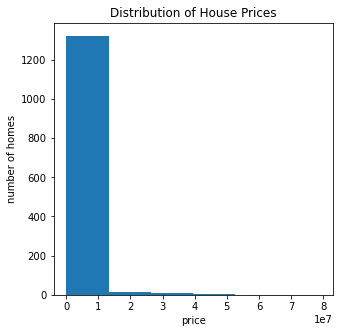

In [34]:
plt.figure(figsize=(5,5))
plt.hist(df['price'], bins = 6 )
plt.title("Distribution of House Prices")
plt.xlabel('price')
plt.ylabel('number of homes')

In [513]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   bed                       1348 non-null   int64  
 1   bath                      1348 non-null   int64  
 2   sqft                      1348 non-null   float64
 3   year_built                1348 non-null   int64  
 4   House_age                 1348 non-null   int64  
 5   lot_size                  1144 non-null   float64
 6   house_type                1348 non-null   object 
 7   heating                   1348 non-null   object 
 8   cooling                   1348 non-null   object 
 9   parking                   1348 non-null   object 
 10  num_photos                1348 non-null   int64  
 11  zip                       1348 non-null   int64  
 12  population                1348 non-null   float64
 13  density                   1348 non-null   float64
 14  Average 

In [514]:
df['sqft'].describe()


count      1348.000000
mean       2444.149852
std        5134.094390
min         280.000000
25%        1147.250000
50%        1550.000000
75%        2318.000000
max      122606.000000
Name: sqft, dtype: float64

In [35]:
#Because distribution is heavily right skewed, it is worthwhile to drop pricier homes(over 2M). 
#Otherwise they will skew our models predictions.

#In order to filter out the higher priced homes, I will assign a threshold value to an important feature like
#sqft. That way all homes above that threshold square footage will be removed from my dataframe:

#Originally I dropped rows of homes with square ft over 3000, 
#but that still didn't filter out a significant amount of homes over 2M, so I decided to also filter by price

#to create a more gaussian distribution, I will drop all rows(homes) where sqft is more than 3000
df = df[df['sqft'] < 3000]
df = df[df['price'] < 1500000]
 


#mask=(df['sqft'] >= 3000 )


#df=df[mask]


#mask= df.where(df['sqft'].gt(3000))
#df=df[mask]


#df= df.where(df.sqft.gt(3000))

#max sqft: 122606.0


In [516]:
df.shape

(1052, 16)

In [174]:
''''This was code to check out how many homes fit each price bracket, 
essentially how I double checked my 2M price cut-off



#bracket1 = df.loc[df['price'] < 200000].count()
#bracket1 --> 42 houses
#bracket2 = df[df['price'].between(200000, 300000)].count()
#bracket2 --> 79
#bracket3 = df[df['price'].between(300000, 400000)].count()
#bracket3 -->103
#bracket4 = df[df['price'].between(400000, 500000)].count()
#bracket4 --> 145
#bracket5 = df[df['price'].between(600000, 700000)].count()
#bracket5 --> 191
#bracket6 = df[df['price'].between(700000, 800000)].count()
#bracket6 --> 129
#bracket7 = df[df['price'].between(800000, 900000)].count()
#bracket7 --> 92
#bracket8 = df[df['price'].between(900000, 1000000)].count()
#bracket8 --> 61
#bracket9 = df[df['price'].between(1000000, 2000000)].count()
#bracket9 --> 155
#bracket10 = df[df['price'].between(2000000, 3000000)].count()
#bracket10 --> 65
#bracket11 = df[df['price'].between(3000000, 4000000)].count()
#bracket11 --> 25
#bracket12 = df[df['price'].between(4000000, 5000000)].count()
#bracket12 #--> 16
#bracket13 = df.loc[df['price'] > 5000000].count()
#bracket13 #--> 67

#df['price'].max()--> 79 mil


#to create a more gaussian distribution, I will drop values higher than 3000000
######df = df[df['price'] < 2000000]

#check
#df['price'].max() #--> 999999.0l, just below 2 mil '''

Text(0, 0.5, 'number of homes')

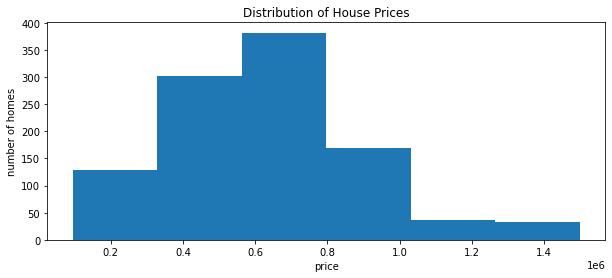

In [36]:
#More normally distributed data
plt.figure(figsize=(10,4))
plt.hist(df['price'], bins = 6 )
plt.title("Distribution of House Prices")
plt.xlabel('price')
plt.ylabel('number of homes')

In [518]:
df.shape

(1052, 16)

/Users/aimanchughtai/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

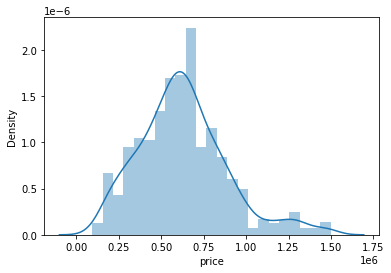

In [37]:
#distribution of the target variable 
sns.distplot(df['price'])

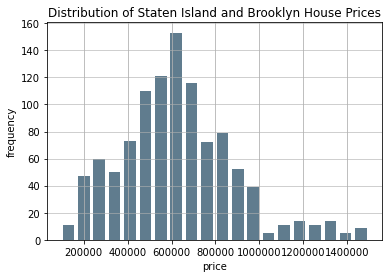

In [38]:
#Another plot of the home value distribution:

price = df['price']
price.plot.hist(grid=True, bins=20, rwidth=0.75,
                   color='#607c8e')
plt.title('Distribution of Staten Island and Brooklyn House Prices')
plt.xlabel('price')
plt.ylabel('frequency')
plt.grid(axis='y', alpha=0.75)
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)

In [39]:
#explore relationships with pair plot using select numerical features: 
df2= df[['bed','bath','sqft','year_built','House_age','lot_size', 'num_photos','zip','population', 'density', 'Average household income', 'price']]


#Temporarily fillna lot_size with 0's
df2['lot_size'] = df['lot_size'].fillna(0)

#check
#df2.info()
df2.head(2)





<ipython-input-39-865137491f91>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['lot_size'] = df['lot_size'].fillna(0)


,bed,bath,sqft,year_built,House_age,lot_size,num_photos,zip,population,density,Average household income,price
1,4,2,1629.0,1930,91,5057.0,3,11412,37857.0,8874.3,48536.0,330000.0
2,3,3,1800.0,2003,18,1711.0,25,10314,89792.0,2534.2,59560.0,559000.0


In [40]:
#Numerical feature dataframe:

df2.head(2)

,bed,bath,sqft,year_built,House_age,lot_size,num_photos,zip,population,density,Average household income,price
1,4,2,1629.0,1930,91,5057.0,3,11412,37857.0,8874.3,48536.0,330000.0
2,3,3,1800.0,2003,18,1711.0,25,10314,89792.0,2534.2,59560.0,559000.0


In [169]:
df3.head(2)

,house_type,heating,cooling,parking
1,SingleFamily,No Data,No Data,"Garage - Detached,"
2,SingleFamily,"Forced air, Gas",Central,"Carport,"


In [179]:
concatenated = pd.concat([df2, df3], axis=1)
concatenated.head(3)

,bed,bath,sqft,year_built,House_age,lot_size,num_photos,zip,population,density,Average household income,price,house_type,heating,cooling,parking
1,4,2,1629.0,1930,91,5057.0,3,11412,37857.0,8874.3,48536.0,330000.0,SingleFamily,No Data,No Data,"Garage - Detached,"
2,3,3,1800.0,2003,18,1711.0,25,10314,89792.0,2534.2,59560.0,559000.0,SingleFamily,"Forced air, Gas",Central,"Carport,"
3,4,3,1860.0,1960,61,4000.0,68,10308,29512.0,5789.0,61868.0,738888.0,Single Family - Detached,"Forced Air, Natural Gas",Central Air,"Built-in, Garage, Off Street"


In [184]:
concatenated['heating'] = concatenated['heating'].apply(lambda x: x.replace('No Data','NaN'))
concatenated['cooling'] = concatenated['cooling'].apply(lambda x: x.replace('No Data','NaN'))  
concatenated['parking'] = concatenated['parking'].apply(lambda x: x.replace('No Data','NaN')) 

In [185]:
concatenated['heating'] = concatenated['heating'].fillna(0)                                    
concatenated['cooling'] = concatenated['cooling'].fillna(0)                                    
concatenated['parking'] = concatenated['parking'].fillna(0)

concatenated.isna().sum()
                          

bed                         0
bath                        0
sqft                        0
year_built                  0
House_age                   0
lot_size                    0
num_photos                  0
zip                         0
population                  0
density                     0
Average household income    0
price                       0
house_type                  0
heating                     0
cooling                     0
parking                     0
dtype: int64

In [186]:
concatenated['house_type'].unique()

array(['SingleFamily', 'Single Family - Detached', 'MultiFamily',
       'Single Family - Attached', 'Two Family - Detached', 'Condo',
       'Single Family Residence', 'Single Family - Semi-Attached',
       'Cooperative', 'Apartment', 'Stock Cooperative', 'Multi Family',
       'Two Family - Semi-Attached', 'Condominium',
       'Two Family - Attached', 'Townhouse'], dtype=object)

# !!!!!!!!!!!!

In [274]:
#Categorical feature dataframe:

#df3= df[['house_type', 'heating', 'cooling','parking']]
#df3.head(2)



dummified1 = pd.get_dummies(concatenated['house_type'])
dummified2 = pd.get_dummies(concatenated['heating'])
dummified3 = pd.get_dummies(concatenated['cooling'])
dummified4 = pd.get_dummies(concatenated['parking'])
X_all_concat = pd.concat([concatenated, dummified1, dummified2, dummified3, dummified4, ], axis = 1)

X_all_concat.head(3)



,bed,bath,sqft,year_built,House_age,lot_size,num_photos,zip,population,density,Average household income,price,house_type,heating,cooling,parking,Apartment,Condo,Condominium,Cooperative,Multi Family,MultiFamily,Single Family - Attached,Single Family - Detached,Single Family - Semi-Attached,Single Family Residence,SingleFamily,Stock Cooperative,Townhouse,Two Family - Attached,Two Family - Detached,Two Family - Semi-Attached,Baseboard,"Baseboard, Electric","Baseboard, Forced air, Gas","Baseboard, Gas","Baseboard, Heat pump, Electric, Gas","Baseboard, Other, Radiant, Gas",Electric,"Electric, Forced Air","Electric, Forced Air, Other, Fireplace(s)","Electric, Gas","Electric, Natural Gas","Electric, Natural Gas, Forced Air",Forced Air,"Forced Air, Electric","Forced Air, Hot Water, Natural Gas","Forced Air, Hot Water, Natural Gas, Fireplace(s)","Forced Air, Natural Gas","Forced Air, Natural Gas, Fireplace(s)","Forced Air, Oil","Forced Air, Other, Electric",Forced air,"Forced air, Gas","Forced air, Radiant, Gas",Gas,"Heat pump, Other, Electric","Hot Water, Electric","Hot Water, Electric, Natural Gas","Hot Water, Electric, Oil","Hot Water, Natural Gas","Hot Water, Natural Gas, Fireplace(s)","Hot Water, Oil","Hot Water, Oil, Fireplace(s)","Hot Water, Other, Natural Gas","Hot Water, Other, Natural Gas, Fireplace(s)","Hot Water, Steam, Natural Gas","Hot Water, Steam, Natural Gas, Fireplace(s)","Hot Water, Steam, Natural Gas, Oil",NaN,Natural Gas,"Natural Gas, Baseboard","Natural Gas, Baseboard, Hot Water","Natural Gas, Baseboard, Hot Water, Steam","Natural Gas, Ductless/Split, Forced Air","Natural Gas, ENERGY STAR Qualified Equipment","Natural Gas, Forced Air","Natural Gas, Forced Air, Hot Water","Natural Gas, Heat Pump, Forced Air","Natural Gas, Hot Water","Natural Gas, Hot Water, Steam","Natural Gas, Oil, Baseboard","Natural Gas, Oil, Other","Natural Gas, Other","Natural Gas, Other, Steam","Natural Gas, Solar","Natural Gas, Steam","Natural Gas, Steam/Radiator",None,"None, Forced air",Oil,"Oil, Baseboard","Oil, Baseboard, Hot Water","Oil, Hot Water","Oil, Steam","Oil, Steam/Radiator",Other,"Other, Baseboard","Other, Electric","Other, Forced Air","Other, Gas","Other, Natural Gas","Other, Natural Gas, Fireplace(s)","Other, Oil","Other, Other","Other, See Remarks",Radiant,"Radiant, Gas","Steam, Electric, Natural Gas, Oil, Fireplace(s)","Steam, Natural Gas","Steam, Natural Gas, Fireplace(s)","Steam, Oil","Steam, Oil, Fireplace(s)",Steam/Radiator,"Wall, Gas",A/C Unit,"A/C Unit, Central Air","A/C Unit, Wall Unit(s)",Central,Central Air,Central Air - Split,"Central Air, Central Air - Split","Central Air, ENERGY STAR Qualified Equipment","Central, Wall",Ductless,NaN,None,"None, ENERGY STAR Qualified Equipment",Other,Units,"Units, ENERGY STAR Qualified Equipment",Wall,Wall Unit(s),"Wall Unit(s), Window Unit(s)",Window Unit(s),Zoned,0 spaces,1 Space,2 Spaces,Assigned,"Assigned, Garage","Assigned, Parking Lot, Waitlist","Attached, 1 Car Attached, On Street","Attached, Built-in, Garage, Assigned","Attached, Built-in, Garage, Carport, Off Street, On Street","Attached, Built-in, Garage, Carport, On Street","Attached, Built-in, Garage, Off Street","Attached, Built-in, Garage, Off Street, Garage Door Opener","Attached, Built-in, Garage, On Street","Attached, Covered, Garage, Underground","Attached, Detached, Garage, Off Street, On Street","Attached, Garage, Assigned","Attached, Garage, Assigned, Off Street","Attached, Garage, Assigned, Off Street, On Street","Attached, Garage, Carport, Off Street","Attached, Garage, Carport, Off Street, Garage Door Opener","Attached, Garage, Carport, On Street, Garage Door Opener","Attached, Garage, Off Street","Attached, Garage, Off Street, Garage Door Opener","Attached, Garage, Off Street, On Street","Attached, Garage, Off Street, On Street, Garage Door Opener","Attached, Garage, On Street","Attached, No Garage, Off Street, On Street","Built-in, Attached, Garage, Assigned","Built-in, Attached, Garage, Carport, Garage D

In [42]:
df2['sqft'].mean()
df2['sqft'].describe()

count    1052.000000
mean     1454.285171
std       546.718317
min       280.000000
25%      1064.000000
50%      1396.000000
75%      1800.000000
max      2986.000000
Name: sqft, dtype: float64

In [43]:
df2.isna().sum()

bed                         0
bath                        0
sqft                        0
year_built                  0
House_age                   0
lot_size                    0
num_photos                  0
zip                         0
population                  0
density                     0
Average household income    0
price                       0
dtype: int64

In [526]:
df2.shape

(1052, 12)

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

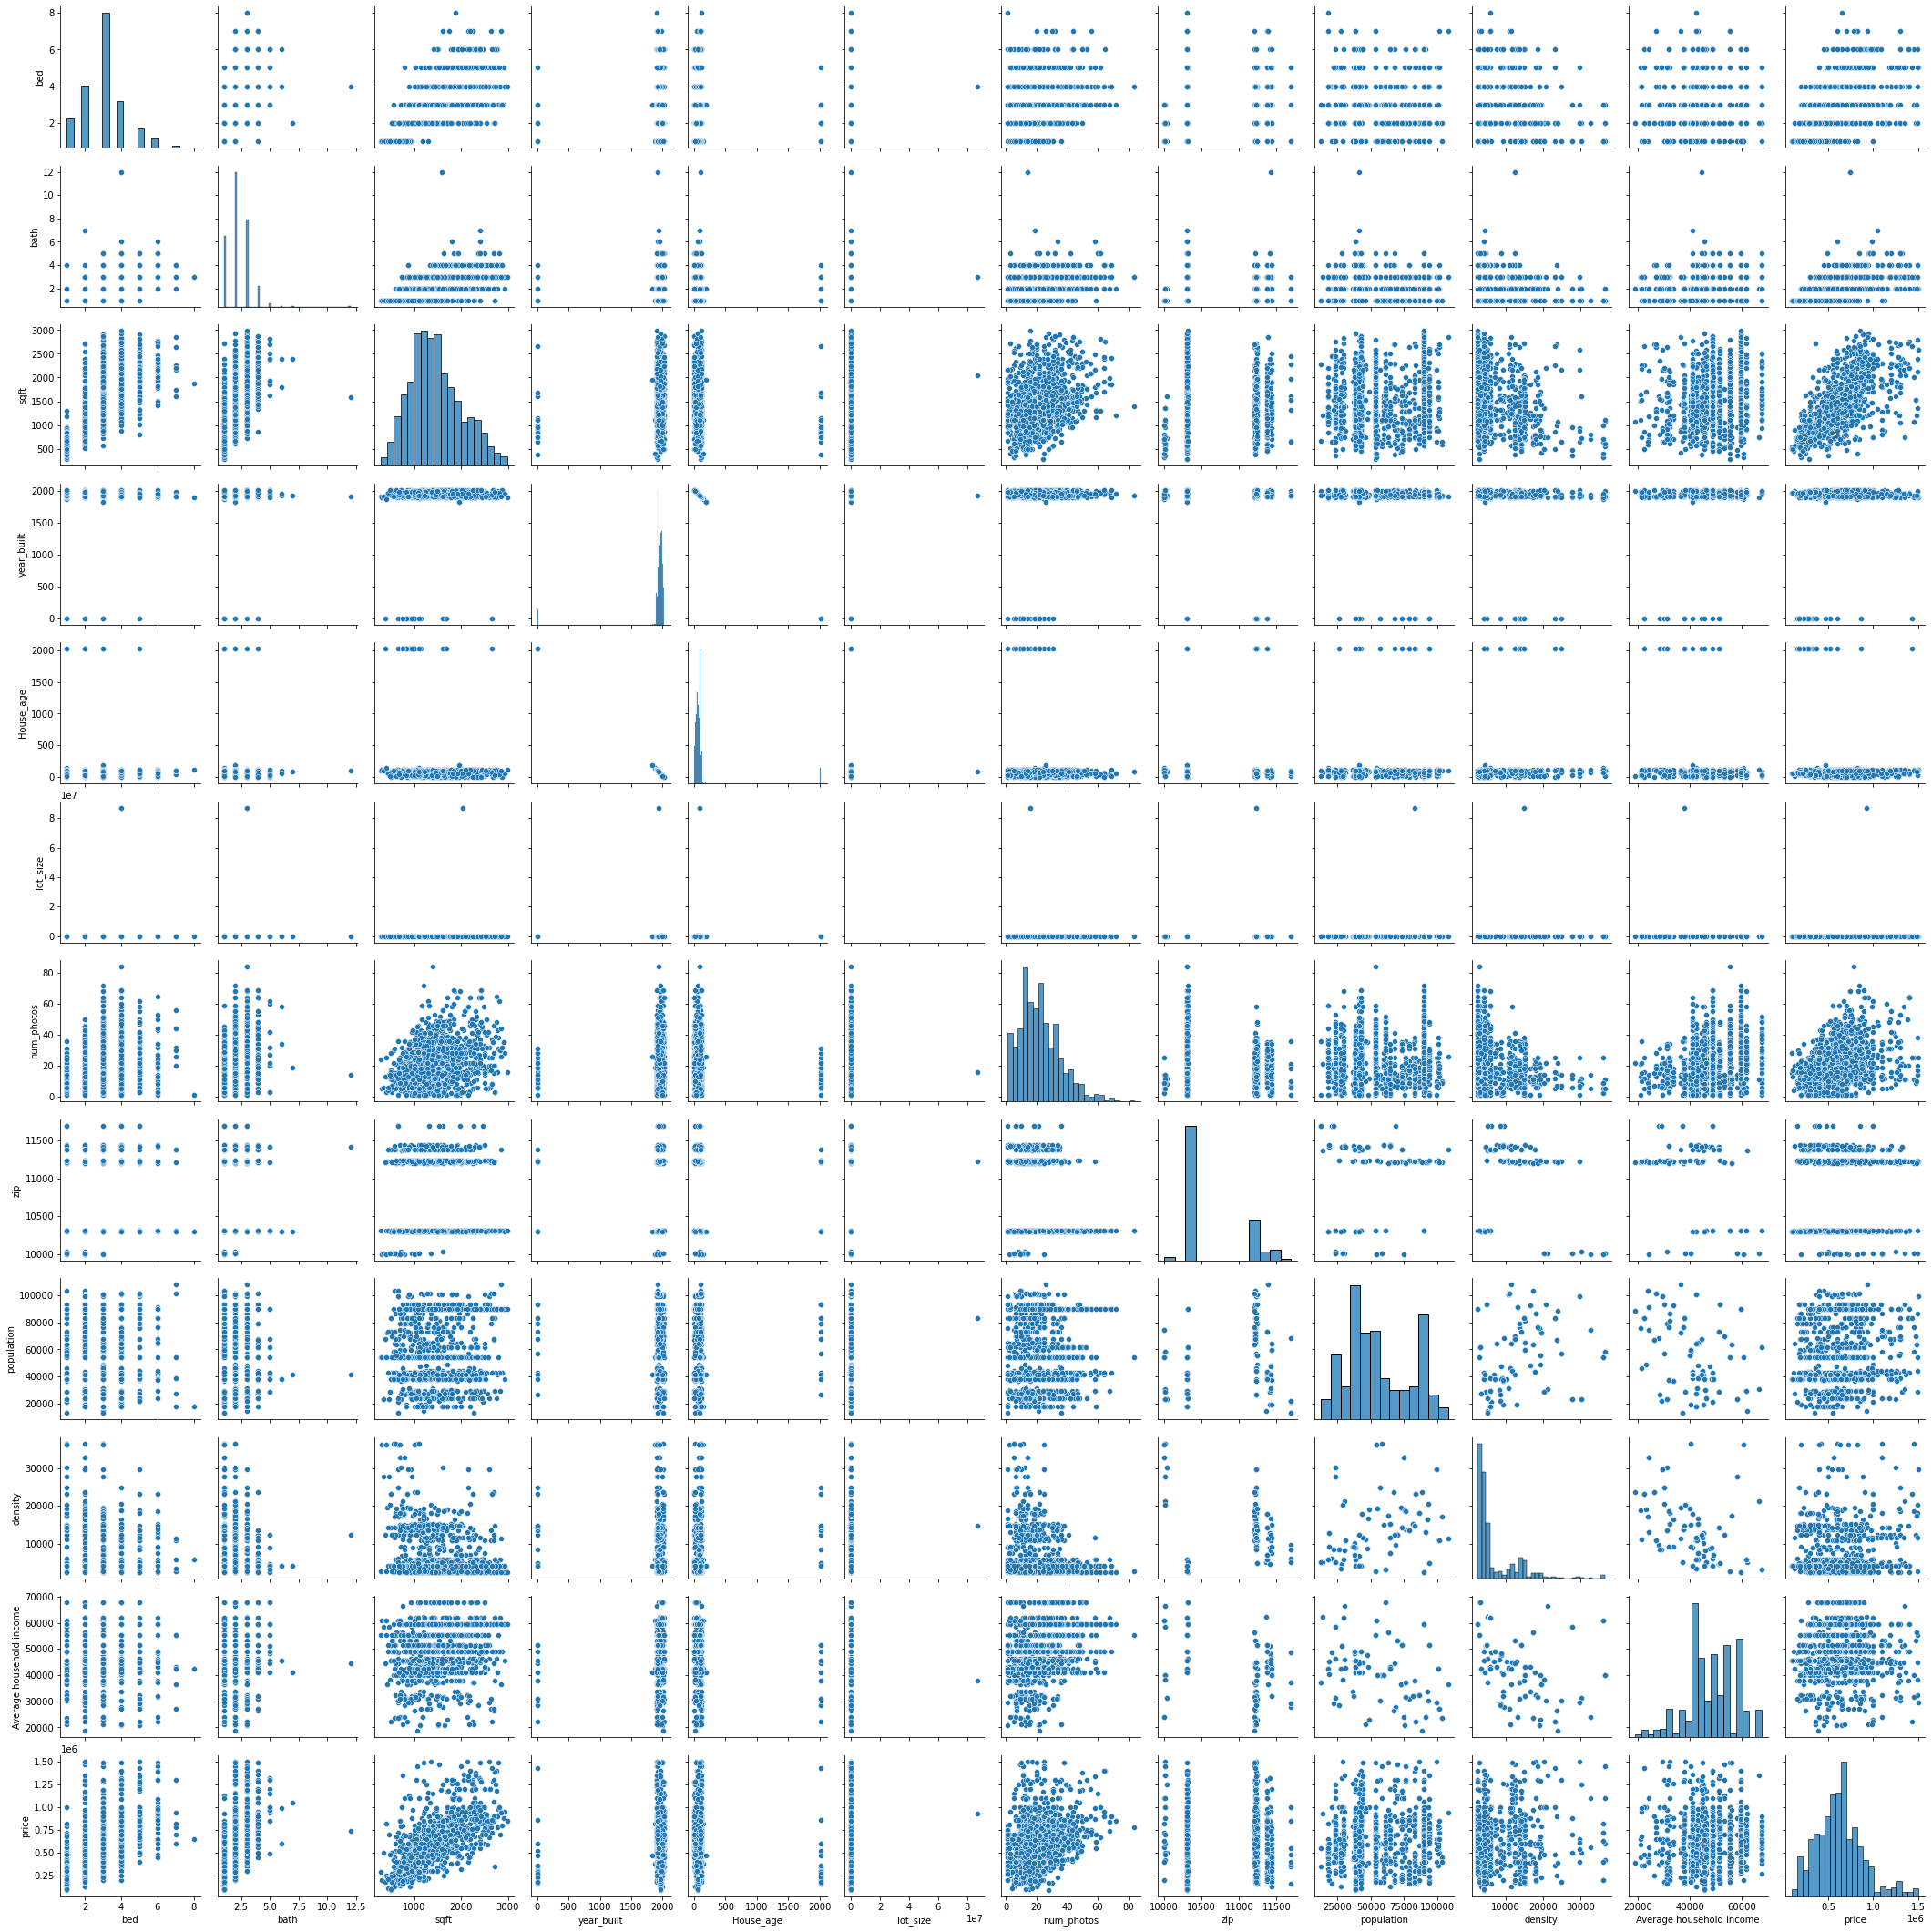

In [45]:
sns.pairplot(df2)

From first glance it seems my main numerical features, (bed, bath, sqft and num_photos) seem to be positively correlated with price (the target)- which is what we'd expect. No obvious distribution issues as well, some slight skewing for num_photos and density. Interestingly, it doesnt seem like there's much of a relationship (especially not a linear one) between my census features (population, density and average household income) and price. 

<AxesSubplot:>

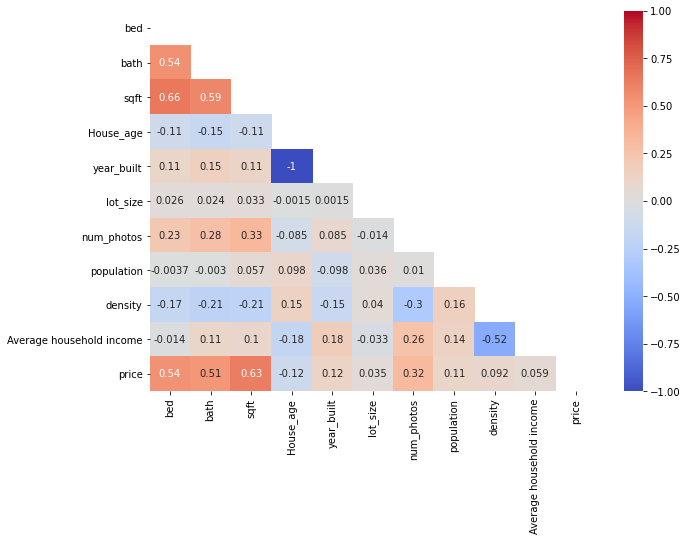

In [334]:
#heatmap to see correlations:

upper = np.triu(df2.corr()) 
plt.figure(figsize=(10, 7))
sns.heatmap(df2.corr(), cmap="coolwarm", annot=True, vmin=-1, vmax=1, mask=upper)

Seems that bed and bath have a similar relationship with price. Let's check VIF for multicolinearity: 

In [306]:
#VIF calculation:

def vif(df_X):
    
    vif_data = [variance_inflation_factor(df_X.values, i)
                for i in range(df_X.shape[1])]
    
    return pd.Series(vif_data, index=df_X.columns)

In [307]:
vif(df2.iloc[:, :11])

bed                           1.926478
bath                          1.687584
sqft                          2.143250
year_built                  934.379448
House_age                    22.992635
lot_size                      1.005073
num_photos                    1.247923
zip                           1.731248
population                    1.263934
density                       1.756740
Average household income      1.771456
dtype: float64

VIF tells us how much the variance is inflated due to multicolinearity of features. These values are very small (except for year_built which has been fillna'd with 0's)
This mean that the standard error of the predictor wouldn't be much lower if there was 
multicolinearity happening.

# Building a Baseline Model:

In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import math
from sklearn.metrics import mean_squared_error
from math import sqrt
import sklearn.metrics as metrics
pd.options.display.max_columns = None
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [308]:
# Create an empty model
lm = LinearRegression()

In [310]:
#Fitting a simple model to include only numeric features


#Features 
X = df2[['bed', 'bath', 'sqft', 'House_age', 'year_built','lot_size', 'num_photos', 'population', 'density','Average household income']]

#Target

y= df2['price']

In [311]:
#Split the data 80 - 20 train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state = 36)

In [312]:
std = StandardScaler()

std.fit(X_train.values)


StandardScaler()

In [313]:
X_tr = std.transform(X_train.values)

In [314]:
X_te = std.transform(X_test.values)

In [315]:
# Fit  
lm.fit(X_tr, y_train)

LinearRegression()

In [316]:
lm.score(X_tr, y_train)

0.5730299473521702

In [317]:
lm.score(X_te, y_test)

0.46353884239458276

In [57]:
# Compare the actual y values in the training set with the predicted values
y_actual_train = y_train
y_predicted_train = lm.predict(X_tr)
y_predicted_train.shape

(841,)

In [318]:
# Check the RMSE (root mean squared error) on the training data
sqrt(mean_squared_error(y_actual_train, y_predicted_train))

167761.58540073226

In [59]:
# Compare the actual y values in the test set with the predicted values
y_actual_test = y_test
y_predicted_test = lm.predict(X_te)
y_predicted_test.shape

(211,)

In [319]:
# Check the RMSE (root mean squared error) on the test data
sqrt(mean_squared_error(y_actual_test, y_predicted_test))

199812.0012174944

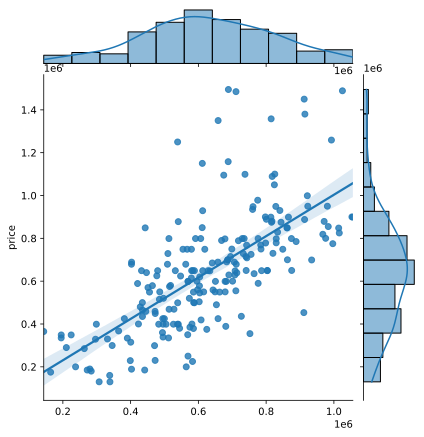

In [61]:
preds = lm.predict(X_te)

sns.jointplot(x=preds,y=y_test, kind='reg')

In [320]:
#Get summary metrics: 

#Create the model
model = sm.OLS(y_train, sm.add_constant(X_tr)) 

#Fit
fit = model.fit()

#Print out summary
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     125.8
Date:                Fri, 11 Jun 2021   Prob (F-statistic):          1.44e-148
Time:                        08:54:41   Log-Likelihood:                -11307.
No. Observations:                 841   AIC:                         2.263e+04
Df Residuals:                     831   BIC:                         2.268e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.232e+05   5794.740    107.544      0.000    6.12e+05    6.35e+05
x1          5.765e+04   8128.268      7.093      0.000    4.17e+04    7.36e+04
x2          4.072e+04   7440.517      5.473      0.000    2.61e+04    5.53e+04
x3          1.047e+05   8589.811     12.192      0.000    8.79e+04    1.22e+05
x4         -5833.3718   2990.459     -1.951      0.051   -1.17e+04      36.369
x5          5833.3718   2990.459      1.951      0.051     -36.369    1.17e+04
x6          1362.1404   5812.459      0.234      0.815      -1e+04    1.28e+04
x7          4.234e+04   6461.494      6.553      0.000    2.97e+04     5.5e+04
x8          6249.9760   6256.036      0.999      0.318   -6029.514    1.85e+04
x9          8.602e+04   7526.283     11.430      0.000    7.13e+04    1.01e+05
x10         2.918e+04   7458.891      3.912      0.000    1.45e+04    4.38e+04
==============================================================================
Omnibus:                       94.379   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              196.837
Skew:                           0.666   Prob(JB):                     1.81e-43
Kurtosis:                       4.961   Cond. No.                     1.27e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.43e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Test and Validate (without categorical features)

In [321]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on training & validation data
    train_score = lr_model.score(X_train, y_train)
    val_score = lr_model.score(X_val, y_val)
    
    # report training results
    print('\nTraining R^2 score:', train_score)
    
    # report validation results
    print('\nValidation R^2 score:', val_score)
    print('Feature coefficients: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}')

In [322]:
split_and_validate(X, y)


Training R^2 score: 0.5659749495244863

Validation R^2 score: -164.89455233364828
Feature coefficients: 

bed : 51808.52
bath : 38926.28
sqft : 192.47
House_age : -23.26
year_built : 23.26
lot_size : -0.52
num_photos : 3242.12
population : 0.08
density : 16.99
Average household income : 4.30


In [323]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

141648.12741915695

In [324]:
# Check the RMSE (root mean squared error) on the test data
sqrt(mean_squared_error(y_actual_test, y_predicted_test))

199812.0012174944

In [325]:
#Cross Validation: 

def cross_val(X,y):
    lm = LinearRegression()
    kf = KFold(n_splits=5, shuffle=True, random_state = 71)
    cv_lm_r2s = cross_val_score(lm, X, y, cv=kf, scoring='r2')
    print(f'\nSimple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')

## Adding Poly Features: 

In [326]:
def poly_version(X,y): #Create polynomial features
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=21)
    
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    lr_poly = LinearRegression()
    fit = lr_poly.fit(X_train_poly,y_train)
    train_score = lr_poly.score(X_train_poly, y_train)
    val_score = lr_poly.score(X_val_poly, y_val)
    print('\nPoly Validation R^2 score was:', val_score)
    y_pred_val = lr_poly.predict(X_val_poly)
    y_pred_train = lr_poly.predict(X_train_poly)
#     print(y_pred.shape)

    print('\nTraining R^2 score was:', train_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_poly.coef_):
         print(feature, ':', coef)
    model = sm.regression.linear_model.OLS(y_train, sm.add_constant(X_train_poly))
    fit = model.fit(intercept = True)
    print(fit.summary())
    return y_pred_val, y_val, X_val_poly, y_pred_train, y_train, X_train_poly, fit

In [327]:
def poly_cv(X,y):
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    kf = KFold(n_splits=5, shuffle=True, random_state = 60)
    lr_poly = LinearRegression()
    lr_poly.fit(X_poly, y)
    cv_lm_poly = cross_val_score(lr_poly, X_poly, y, cv=kf, scoring='r2')
    y_pred = lr_poly.predict(X_poly)
    
    print(f'\nPoly Simple mean cv r^2: {np.mean(cv_lm_poly):.3f} +- {np.std(cv_lm_poly):.3f}\n')

In [328]:
num_columns = ['bed', 'bath', 'sqft', 'House_age', 'year_built','lot_size', 'num_photos', 'population', 'density','Average household income']
X = X_train.loc[:,num_columns]
y = y_train
split_and_validate(X, y)
cross_val(X,y)
y_preds1, y_val1 = poly_version(X,y)
poly_cv(X,y)
sns.jointplot(x=y_preds1,y=y_val1, kind='reg', xlim = (-30, 20), ylim = (-30,30))


Training R^2 score: 0.6081837471991511

Validation R^2 score: 0.44561863920188804
Feature coefficients: 

bed : 54435.03
bath : 31924.26
sqft : 194.03
House_age : -29.61
year_built : 29.61
lot_size : 0.00
num_photos : 3576.00
population : 0.28
density : 14.26
Average household income : 2.76

Simple mean cv r^2: -52.039 +- 105.211

Poly Validation R^2 score was: 0.3469223251599731

Training R^2 score was: 0.6692685130584944
Feature coefficient results: 

bed : -0.037276535580451325
bath : -1.2965990660369937
sqft : 0.077605504428187
House_age : 0.0075724843866381225
year_built : -0.006305227681663901
lot_size : -0.0026642374233565086
num_photos : -2.0752835702056405e-05
population : -0.000139149378387223
density : 9.620461340264716e-07
Average household income : -0.00012339223485082255
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.669
Model:                            OLS   Adj. 

ValueError: too many values to unpack (expected 2)

## Feature Engineering

In [329]:


X2 = X.copy()


X2['bed2'] = X['bed'] ** 2
X2['bath2'] = X['bath'] ** 2
X2['bed_per_sqft'] = X['bed']/ X['sqft']
X2['bath_per_sqft'] = X['bath']/ X['sqft']
X2['sqft_X_house_age'] = X['sqft']* X['House_age']
X2['sqft_X_num_photos'] = X['sqft']* X['num_photos']



split_and_validate(X2, y)
cross_val(X2,y)
y_preds2, y_val2 = poly_version(X2,y)
poly_cv(X2,y)



Training R^2 score: 0.6176857048365525

Validation R^2 score: 0.45280726354820156
Feature coefficients: 

bed : 107716.95
bath : 37259.13
sqft : 150.00
House_age : -87.68
year_built : 87.69
lot_size : 0.00
num_photos : 1926.61
population : 0.28
density : 14.30
Average household income : 2.83
bed2 : -5364.46
bath2 : -3865.15
bed_per_sqft : -27232741.55
bath_per_sqft : 35809291.64
sqft_X_house_age : 0.12
sqft_X_num_photos : 0.96

Simple mean cv r^2: -46.816 +- 94.763

Poly Validation R^2 score was: -13.547475918321833

Training R^2 score was: 0.7269592020773518
Feature coefficient results: 

bed : 0.3228407911985449
bath : 467.01052501970634
sqft : -107.3320162828607
House_age : 4.115458377847946
year_built : -4.128230136601647
lot_size : 0.44947577282548606
num_photos : 1.0761302174847296
population : 0.008167676475090885
density : 0.19344157533149214
Average household income : -0.04482488361841274
bed2 : 0.2850501271998764
bath2 : -0.2658135427962468
bed_per_sqft : -0.0082223095853067

ValueError: too many values to unpack (expected 2)

In [216]:

#concatenated.drop(['price'], axis = 1)


#concatenated.columns


#X_all= concatenated.columns

#print(X_all)



In [330]:
dummified= pd.concat([pd.get_dummies(concatenated[['parking', 'heating', 'cooling', 'house_type']]), df[['bed', 'bath', 'sqft', 'year_built','House_age', 'lot_size', 'num_photos', 'zip', 'population', 'density', 'Average household income', 'price']]], axis=1)

In [331]:
dummified.head(2)

,parking_0 spaces,parking_1 Space,parking_2 Spaces,parking_Assigned,"parking_Assigned, Garage","parking_Assigned, Parking Lot, Waitlist","parking_Attached, 1 Car Attached, On Street","parking_Attached, Built-in, Garage, Assigned","parking_Attached, Built-in, Garage, Carport, Off Street, On Street","parking_Attached, Built-in, Garage, Carport, On Street","parking_Attached, Built-in, Garage, Off Street","parking_Attached, Built-in, Garage, Off Street, Garage Door Opener","parking_Attached, Built-in, Garage, On Street","parking_Attached, Covered, Garage, Underground","parking_Attached, Detached, Garage, Off Street, On Street","parking_Attached, Garage, Assigned","parking_Attached, Garage, Assigned, Off Street","parking_Attached, Garage, Assigned, Off Street, On Street","parking_Attached, Garage, Carport, Off Street","parking_Attached, Garage, Carport, Off Street, Garage Door Opener","parking_Attached, Garage, Carport, On Street, Garage Door Opener","parking_Attached, Garage, Off Street","parking_Attached, Garage, Off Street, Garage Door Opener","parking_Attached, Garage, Off Street, On Street","parking_Attached, Garage, Off Street, On Street, Garage Door Opener","parking_Attached, Garage, On Street","parking_Attached, No Garage, Off Street, On Street","parking_Built-in, Attached, Garage, Assigned","parking_Built-in, Attached, Garage, Carport, Garage Door Opener","parking_Built-in, Attached, Garage, Off Street","parking_Built-in, Detached, Garage, Off Street","parking_Built-in, Garage, Assigned","parking_Built-in, Garage, Assigned, Carport","parking_Built-in, Garage, Assigned, Garage Door Opener","parking_Built-in, Garage, Assigned, Off Street","parking_Built-in, Garage, Assigned, On Street","parking_Built-in, Garage, Carport","parking_Built-in, Garage, Carport, Garage Door Opener","parking_Built-in, Garage, Carport, Off Street","parking_Built-in, Garage, Carport, Off Street, Garage Door Opener","parking_Built-in, Garage, Carport, On Street, Garage Door Opener","parking_Built-in, Garage, Off Street","parking_Built-in, Garage, Off Street, Garage Door Opener","parking_Built-in, Garage, Off Street, On Street","parking_Built-in, Garage, Off Street, On Street, Garage Door Opener","parking_Built-in, Garage, On Street","parking_Built-in, No Garage, Assigned","parking_Built-in, No Garage, On Street",parking_Carport,"parking_Carport,","parking_Carport, 1 Space","parking_Carport, 1 Space, 2 Spaces","parking_Carport, 2 Spaces","parking_Carport, 2 Spaces, Built-In Garage","parking_Carport, 3 Spaces","parking_Carport, Detached Garage","parking_Carport, Garage - Attached","parking_Carport, Garage - Attached,","parking_Carport, Garage - Attached, Off-street","parking_Carport, Garage - Detached,","parking_Carport, Garage - Detached, Off-street","parking_Carport, Off-street","parking_Carport, Off-street,","parking_Common, Parking Lot, Off Street","parking_Community Drive, 2 Spaces","parking_Detached, 1 Car Detached, Driveway, On Street","parking_Detached, Garage, Carport","parking_Detached, Garage, Carport, Garage Door Opener","parking_Detached, Garage, Carport, Off Street","parking_Detached, Garage, Carport, Off Street, Garage Door Opener","parking_Detached, Garage, Carport, Off Street, On Street","parking_Detached, Garage, Off Street","parking_Detached, Garage, Off Street, Garage Door Opener","parking_Detached, Garage, Off Street, On Street","parking_Detached, Garage, Off Street, On Street, Garage Door Opener","parking_Detached, Garage, On Street","parking_Detached, No Garage, Assigned","parking_Detached, No Garage, Off Street","parking_Detached, No Garage, Off Street, On Street","parking_Detached, No Garage, On Street","parking_Detached, Off Street",parking_Driveway,"parking_Driveway, Garage","parking_Driveway, On Street",parking_Garage,parking_Garage - Attached,"parking_Garage - Attached,","parking_Garage - Attached, Off-street,","parking_Garage - Attached, Off-street, On-street","parking_Garage - Attached, Off-street, On-street,",parking_Gara

## Integrate categorical features: Dummy variables/One-Hot-Encoding

In [203]:
#df3['house_type'].value_counts()

In [204]:
#pd.get_dummies(df3['house_type']).head()

In [332]:
X3 = X2.copy()

X3['house_type'] = df3['house_type']

split_and_validate(pd.get_dummies(X3), y)


Training R^2 score: 0.6889129588003685

Validation R^2 score: 0.48906943415187554
Feature coefficients: 

bed : 77550.14
bath : 83800.11
sqft : 31.80
House_age : -69.08
year_built : 68.91
lot_size : 0.00
num_photos : 1652.77
population : 0.09
density : 14.24
Average household income : 3.88
bed2 : -2799.81
bath2 : -5100.36
bed_per_sqft : -45694946.94
bath_per_sqft : -21561619.19
sqft_X_house_age : 0.12
sqft_X_num_photos : 1.12
house_type_Apartment : -106481.03
house_type_Condo : 131517.52
house_type_Condominium : -35808.24
house_type_Cooperative : -107112.56
house_type_Multi Family : -3658.88
house_type_MultiFamily : 150845.69
house_type_Single Family - Attached : -81730.58
house_type_Single Family - Detached : 37172.22
house_type_Single Family - Semi-Attached : -36248.53
house_type_Single Family Residence : -10541.24
house_type_SingleFamily : 92593.48
house_type_Stock Cooperative : -198754.78
house_type_Townhouse : 28405.22
house_type_Two Family - Attached : 59337.78
house_type_Two Fa

In [333]:
X4 = X3.copy()

X4['heating'] = df3['heating']

split_and_validate(pd.get_dummies(X4, drop_first=True), y)


Training R^2 score: 0.7264451156833375

Validation R^2 score: 0.4620579898146794
Feature coefficients: 

bed : 99184.59
bath : 92011.95
sqft : -2.98
House_age : -22.78
year_built : 24.70
lot_size : -0.00
num_photos : 1991.74
population : 0.35
density : 16.03
Average household income : 3.77
bed2 : -3481.75
bath2 : -5769.53
bed_per_sqft : -67194716.15
bath_per_sqft : -22143094.42
sqft_X_house_age : 0.03
sqft_X_num_photos : 0.78
house_type_Condo : 349772.65
house_type_Condominium : 172101.86
house_type_Cooperative : 91447.55
house_type_Multi Family : 185522.12
house_type_MultiFamily : 379953.24
house_type_Single Family - Attached : -2458.11
house_type_Single Family - Detached : 117379.36
house_type_Single Family - Semi-Attached : 46125.50
house_type_Single Family Residence : 206375.62
house_type_SingleFamily : 317841.39
house_type_Stock Cooperative : -50675.77
house_type_Townhouse : 262588.71
house_type_Two Family - Attached : 141161.26
house_type_Two Family - Detached : 136963.08
house_

In [346]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

141648.12741915695

In [347]:
# Check the RMSE (root mean squared error) on the training data
sqrt(mean_squared_error(y_actual_train, y_predicted_train))

167761.58540073226

In [334]:
X5 = X4.copy()

X5['cooling'] = df3['cooling']

split_and_validate(pd.get_dummies(X5, drop_first=True), y)


Training R^2 score: 0.7388019934829573

Validation R^2 score: 0.4566481917888411
Feature coefficients: 

bed : 104516.71
bath : 74779.75
sqft : 8.62
House_age : -38.02
year_built : 40.65
lot_size : 0.00
num_photos : 1906.24
population : 0.48
density : 16.01
Average household income : 3.52
bed2 : -4012.02
bath2 : -5190.58
bed_per_sqft : -61355843.92
bath_per_sqft : -5812014.48
sqft_X_house_age : 0.07
sqft_X_num_photos : 0.70
house_type_Condo : 371872.68
house_type_Condominium : 214711.10
house_type_Cooperative : 149529.36
house_type_Multi Family : 223007.21
house_type_MultiFamily : 431127.52
house_type_Single Family - Attached : -7368.57
house_type_Single Family - Detached : 120911.02
house_type_Single Family - Semi-Attached : 45341.67
house_type_Single Family Residence : 243713.44
house_type_SingleFamily : 371428.38
house_type_Stock Cooperative : 26045.25
house_type_Townhouse : 314243.95
house_type_Two Family - Attached : 131644.48
house_type_Two Family - Detached : 144391.88
house_ty

In [348]:
     


mae(y, test_set_pred)


NameError: name 'y_val' is not defined

In [335]:
X6 = X5.copy()

X6['parking'] = df3['parking']

split_and_validate(pd.get_dummies(X6, drop_first=True), y)


Training R^2 score: 0.7981236729014418

Validation R^2 score: 0.2875195726470371
Feature coefficients: 

bed : 120653.53
bath : 60304.31
sqft : 16.74
House_age : -29.81
year_built : 43.95
lot_size : 0.00
num_photos : 1428.31
population : 0.44
density : 16.33
Average household income : 3.67
bed2 : -4713.76
bath2 : -5344.68
bed_per_sqft : -66553738.47
bath_per_sqft : 10821795.69
sqft_X_house_age : 0.03
sqft_X_num_photos : 0.74
house_type_Condo : 372378.35
house_type_Condominium : 103215.67
house_type_Cooperative : 107942.19
house_type_Multi Family : 55673.85
house_type_MultiFamily : 371567.38
house_type_Single Family - Attached : -36158.24
house_type_Single Family - Detached : 79309.76
house_type_Single Family - Semi-Attached : 5119.76
house_type_Single Family Residence : 263596.69
house_type_SingleFamily : 357194.26
house_type_Stock Cooperative : 4418.10
house_type_Townhouse : 344711.35
house_type_Two Family - Attached : 97300.92
house_type_Two Family - Detached : 102223.74
house_type_

In [336]:
housetype_counts = df.house_type.value_counts()
housetype_counts

Single Family - Detached         237
SingleFamily                     121
Single Family - Attached         114
Single Family - Semi-Attached     94
Cooperative                       78
Two Family - Detached             77
Single Family Residence           75
Apartment                         67
MultiFamily                       48
Condo                             33
Stock Cooperative                 31
Multi Family                      25
Two Family - Semi-Attached        23
Townhouse                         13
Condominium                       11
Two Family - Attached              5
Name: house_type, dtype: int64

In [337]:
#Creating "other" house_type category to aggregate the less common types

other_hstyps = list(housetype_counts[housetype_counts <= 50].index)

X7 = X6.copy()

X7['house_type'] = df3['house_type'].replace(other_hstyps, 'Other')

split_and_validate(pd.get_dummies(X7, drop_first=True), y)


Training R^2 score: 0.7881460183931066

Validation R^2 score: 0.33403048191650075
Feature coefficients: 

bed : 112580.13
bath : 54296.85
sqft : 33.85
House_age : -108.33
year_built : 98.24
lot_size : 0.00
num_photos : 1194.31
population : 0.36
density : 15.63
Average household income : 3.83
bed2 : -4098.18
bath2 : -5260.17
bed_per_sqft : -55210175.86
bath_per_sqft : 19606706.56
sqft_X_house_age : 0.14
sqft_X_num_photos : 0.81
house_type_Cooperative : -44747.16
house_type_Other : 164717.38
house_type_Single Family - Attached : -14260.66
house_type_Single Family - Detached : 101750.72
house_type_Single Family - Semi-Attached : 30662.00
house_type_Single Family Residence : 312031.51
house_type_SingleFamily : 181944.47
house_type_Two Family - Detached : 119294.55
heating_Baseboard, Electric : -0.00
heating_Baseboard, Forced air, Gas : -405322.68
heating_Baseboard, Gas : 73354.11
heating_Baseboard, Heat pump, Electric, Gas : -0.00
heating_Baseboard, Other, Radiant, Gas : -54742.47
heating

In [138]:
#ignore for now, come back to fix later

def add_deviation_feature(X, feature, category):
    
    ''''This function creates features that capture where a feature value lies relative to the members 
    of a category it belongs to. In particular, it will calculate deviance of a row's feature value 
    from the mean value of the category that row belongs to. This helps to capture information about
    a feature relative to the category's distribution, e.g. how nice a house is relative to 
    other houses in its neighborhood or of its style.'''''


    
    # temp groupby object
    category_gb = X.groupby(category)[feature]
    
    # create columns of category means and standard deviations
    category_mean = category_gb.transform(lambda x: x.mean())
    category_std = category_gb.transform(lambda x: x.std())
    
    # compute stds from category mean for each feature value,
    # add to X as new feature
    deviation_feature = (X[feature] - category_mean) / category_std 
    X[feature + '_Dev_' + category] = deviation_feature  

In [148]:
X8 = X7.copy()

add_deviation_feature(X8, 'Condo', 'house_type')
add_deviation_feature(X8, 'MultiFamily', 'house_type')

split_and_validate(pd.get_dummies(X8), y)

KeyError: 'Column not found: Condo'

In [143]:
df3.house_type.unique()

array(['SingleFamily', 'Single Family - Detached', 'MultiFamily',
       'Single Family - Attached', 'Two Family - Detached', 'Condo',
       'Single Family Residence', 'Single Family - Semi-Attached',
       'Cooperative', 'Apartment', 'Stock Cooperative', 'Multi Family',
       'Two Family - Semi-Attached', 'Condominium',
       'Two Family - Attached', 'Townhouse'], dtype=object)

# Regularization

In [338]:
from sklearn.linear_model import (LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, PoissonRegressor, lars_path)
from sklearn.linear_model import (LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, PoissonRegressor, lars_path)
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error)
from sklearn.model_selection import (cross_val_score, cross_val_predict, train_test_split, 
                                     KFold, GridSearchCV)
from sklearn.preprocessing import (StandardScaler, MinMaxScaler, MaxAbsScaler, PolynomialFeatures)
from sklearn.pipeline import Pipeline

In [339]:
std = StandardScaler()
std.fit(X_train.values)

X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

In [340]:
alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [341]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train.columns, lasso_model.coef_))

[('bed', 57569.65616772324),
 ('bath', 40669.51900509251),
 ('sqft', 104725.71616132607),
 ('House_age', -11580.569024003458),
 ('year_built', 7.198093620690383e-12),
 ('lot_size', 1270.1406578173228),
 ('num_photos', 42259.01237882936),
 ('population', 6224.493481630145),
 ('density', 85762.53883214368),
 ('Average household income', 28980.91363363377)]

In [342]:
lasso_model.alpha_

100.0

In [343]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [344]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred)

141648.12741915695

In [345]:
r2_score(y_test, test_set_pred)

0.46192562188231734

In [213]:
dummified.columns

Index(['parking_0 spaces', 'parking_1 Space', 'parking_2 Spaces',
       'parking_Assigned', 'parking_Assigned, Garage',
       'parking_Assigned, Parking Lot, Waitlist',
       'parking_Attached, 1 Car Attached, On Street',
       'parking_Attached, Built-in, Garage, Assigned',
       'parking_Attached, Built-in, Garage, Carport, Off Street, On Street',
       'parking_Attached, Built-in, Garage, Carport, On Street',
       ...
       'sqft', 'year_built', 'House_age', 'lot_size', 'num_photos', 'zip',
       'population', 'density', 'Average household income', 'price'],
      dtype='object', length=283)

In [236]:
dummified2= dummified.drop('price',1)
dummified2.isna().sum()
dummified2.dropna()

dummified2.shape



(1052, 282)

## Run model on Testing Data

In [287]:
#Features 
X = df2[['bed', 'bath', 'sqft', 'House_age', 'year_built','lot_size', 'num_photos', 'population', 'density','Average household income']]

#Target

y= df2['price']

In [288]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)


In [289]:
def test_split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=10)
    
    #Standardize
    std = StandardScaler()
    std.fit(X_train.values)
    X_tr = std.transform(X_train.values)
    X_te = std.transform(X_test.values)
    
    # fit linear regression to training data
    lm = LinearRegression()
    fit = lm.fit(X_train, y_train)
    y_pred = lm.predict(X_val)
    val_score = lm.score(X_val, y_val)
    
    print('\nValidation R^2 score:', val_score)
    print('Feature coefficient: \n')
    for feature, coef in zip(X.columns, lm.coef_):
         print(feature, ':', coef)
        
    model = sm.regression.linear_model.OLS(y_train, sm.add_constant(X_train))
    fit = model.fit(intercept = True)
    
#     print(fit.summary2())
    
    return y_pred, y_val, fit

In [290]:
def test_poly_version(X,y): #Create polynomial features
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=10)
    
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    lr_poly = LinearRegression()
    fit = lr_poly.fit(X_train_poly,y_train)
    train_score = lr_poly.score(X_train_poly, y_train)
    val_score = lr_poly.score(X_val_poly, y_val)
    print('\nPoly Validation R^2 score was:', val_score)
    y_pred_val = lr_poly.predict(X_val_poly)
    y_pred_train = lr_poly.predict(X_train_poly)
#     print(y_pred.shape)

    print('\nTraining R^2 score was:', train_score)
#     print('Feature coefficient results: \n')
#     for feature, coef in zip(X.columns, lr_poly.coef_):
#         print(feature, ':', coef)
    model = sm.regression.linear_model.OLS(y_train, sm.add_constant(X_train_poly))
    fit = model.fit(intercept = True)
    print(fit.summary())
    return y_pred_val, y_val, X_val_poly, y_pred_train, y_train, X_train_poly, fit

In [300]:
mls = LassoCV(cv=5)

pls = PolynomialFeatures(degree=2)

X_train_poly = pls.fit_transform(X)

sls = StandardScaler(with_mean=False)

X_train_poly = sls.fit_transform(X_train_poly)

mls.fit(X_train_poly,y)

y_pred=mls.predict(X_train_poly)
MAE = metrics.mean_absolute_error(y, y_pred)

print("R^2:",mls.score(X_train_poly,y))
print("MAE:",MAE)
print("RMSE:",np.mean(np.sqrt(mls.mse_path_)))

R^2: 0.6067308182440769
MAE: 120517.40411511979
RMSE: 182949.5203985887


/Users/aimanchughtai/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8119179105.953125, tolerance: 5968882986.2959175
  model = cd_fast.enet_coordinate_descent_gram(
/Users/aimanchughtai/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7109089574.8046875, tolerance: 5968882986.2959175
  model = cd_fast.enet_coordinate_descent_gram(
/Users/aimanchughtai/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6783697576.125, tolerance: 5968882986.2959175
  model = cd_fast.enet_coordinate_descent_gram(
/Users/aimanchughtai/opt/anaconda

In [277]:
#dummified1 = pd.get_dummies(concatenated['house_type'])
dummified2 = pd.get_dummies(concatenated['heating'])
dummified3 = pd.get_dummies(concatenated['cooling'])
dummified4 = pd.get_dummies(concatenated['parking'])
X_all_concat = pd.concat([concatenated, dummified2, dummified3, dummified4, ], axis = 1)
y_all = y

test_split_and_validate(X_all_concat, y_all)
cross_val(X_all_concat,y_all)
y_test_pred, y_test, X_test_poly, y_model_pred, y_model, X_model_poly, fit_model = test_poly_version(X_all_concat, y_all)
poly_cv(X_all_concat,y_all)

ValueError: could not convert string to float: 'Single Family - Attached'

## Diagnostic Plots

In [302]:
import scipy.stats as stats
def diagnostic_plots(y_pred, y_true, resid):
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    g1 = sns.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes[0], scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    g1.plot(y_true, y_true, '--', color='gray')

    g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1], line_kws={'color': 'red'}, scatter_kws={'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y=0, color='gray', linestyle='--')

    stats.probplot(resid, dist="norm", plot=axes[2])

    fig.suptitle('Diagnostic Plots');
    fig.tight_layout();

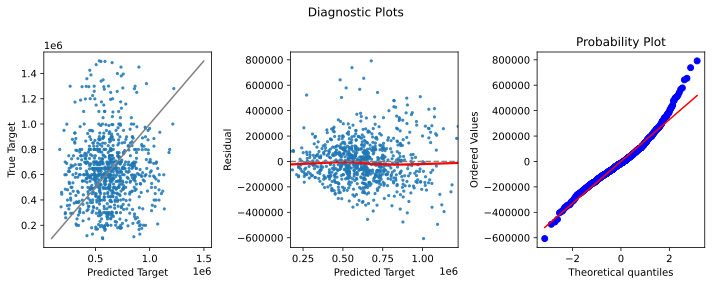

In [303]:
diagnostic_plots(fit.fittedvalues, y_train, fit.resid)